In [1]:
! git init .
! git remote add origin https://github.com/VLSF/SDC
! git pull origin main

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 142 (delta 74), reused 105 (delta 40), pack-reused 0
Receiving objects: 100% (142/142), 27.22 KiB | 9.07 MiB/s, done.
Resolving deltas: 100% (74/74), done.
From https://github.com/VLSF/SDC
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [2]:
import jax.numpy as jnp
from jax import random, jit, config, vmap
from jax.lax import dot_general, scan
from functools import partial
config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [3]:
from datasets import generate_dataset, metrics
from misc import equations, Chebyshev

from integrators import RK4, Explicit_Euler, Implicit_Euler
from sdc_integrators import RK4 as RK4_c, Explicit_Euler as Explicit_Euler_c, Implicit_Euler as Implicit_Euler_c

# Metrics

All our integrators predict $v(t)$ on the fixed interval $[t_i, t_{i+1}]$ where $t_{i+1} = \Delta + t_{i}$. We use standard $L_2$ norm
\begin{equation}
    \left\| a\right\|_2^{[t_{i}, t_{i+1}]} = \left(\int\limits_{t_i}^{t_{i+1}} dt\,a(t)^2\right)^{1/2},
\end{equation}
which we approximate with Clenshaw–Curtis quadrature.


Let $\mathcal{I}$ is an integrator of choice and $v(t)$ is the "exact" solution (e.g., obtained with a more accurate integrator). To measure the performance of $\mathcal{I}$ we use several metrics.

1. Mean one-shot relative $L_2$ error

  Let **$f_{i}$ be features obtained from the exact solution** on the interval $[t_i, t_{i+1}]$. The one-shot $L_2$ error reads
  \begin{equation}
      E_{1}(N) = \underset{{\substack{\text{time}\\ \text{components}}}}{\mathbb{E}} \left[\frac{\left\|v - \mathcal{I}(f_{i})\right\|_2^{[t_i, t_{i+1}]}}{\left\| v\right\|_2^{[t_i, t_{i+1}]}}\right].
  \end{equation}

2. Mean unroll relative $L_2$ error

  In this case we use **approximate features $\hat{f}_{i}$ obtained from the solution given by the integrator $\mathcal{I}(\hat{f}_{i-1})$**
  \begin{equation}
      E_{2}(N) = \underset{{\substack{\text{time}\\ \text{components}}}}{\mathbb{E}}\left[\frac{\left\|v - \mathcal{I}\left(\hat{f}_{i}\right)\right\|_2^{[t_i, t_{i+1}]}}{\left\| v\right\|_2^{[t_i, t_{i+1}]}}\right].
  \end{equation}


3. Total unroll error
  \begin{equation}
      E_{3}(N) = \underset{{\substack{\text{components}}}}{\mathbb{E}}\left[\frac{\left(\sum\limits_{i=1}^{N}\left(\left\|v - \mathcal{I}\left(\hat{f}_{i}\right)\right\|_2^{[t_i, t_{i+1}]}\right)^2\right)^{1/2}}{\left(\sum\limits_{i=1}^{N}\left(\left\| v\right\|_2^{[t_i, t_{i+1}]}\right)^2\right)^{1/2}}\right].
  \end{equation}


4. $\epsilon$-survival time
  
  This is time $t_k$ such that for all interval before the relative error is smaller than $\epsilon$ and for the interval $[t_{k}, t_{k+1}]$ the error is larger that $\epsilon$, i.e,
  \begin{equation}
    t^{\star} = t_k:\,\underset{{\substack{\text{components}}}}{\mathbb{E}}\left[\frac{\left\|v - \mathcal{I}\left(\hat{f}_{i}\right)\right\|_2^{[t_i, t_{i+1}]}}{\left\| v\right\|_2^{[t_i, t_{i+1}]}}\right] \leq \epsilon\,\forall i<k,\,\underset{{\substack{\text{components}}}}{\mathbb{E}}\left[\frac{\left\|v - \mathcal{I}\left(\hat{f}_{k}\right)\right\|_2^{[t_k, t_{k+1}]}}{\left\| v\right\|_2^{[t_k, t_{k+1}]}}\right] > \epsilon.
  \end{equation}




Generate dataset

In [4]:
ODE_data = equations.get_ODE("Lorenz")
integrator = "RK4"
P_u0 = lambda key: random.normal(key, (3,))
key = random.PRNGKey(13)
N_points = 40
T_max = 100
N_intervals = 200
N_SDC = 20
N_samples = 10

dataset, T = generate_dataset.concoct_regular_dataset(ODE_data, integrator, P_u0, T_max, N_points, N_intervals, N_SDC, N_samples, key)
print("shapes for dataset", dataset.shape, T.shape)

shapes for dataset (10, 200, 20, 3, 40) (200, 40)


Check residual

In [5]:
R = generate_dataset.get_residual(dataset, ODE_data, T_max, N_intervals)
print("shape of computed residual", R.shape)
print(jnp.mean(R))

shape of computed residual (10, 200)
3.919968526739276e-14


Define model

In [6]:
def apply_integrator(features, t0, t1, N_SDC):
    solver = RK4.integrator
    corrector = RK4_c.deferred_correction
    values = solver(features, ODE_data["F"], N_points, t0, t1)
    for i in range(N_SDC-2):
        values = corrector(values, ODE_data["F"], t0, t1)
    return values

def features_integrator_one_shot(dataset_t, model_output, features_type):
    return dataset_t[-1, :, 0]

def features_integrator_unroll(dataset_t, model_output, features_type):
    if features_type == "init":
        return dataset_t[-1, :, 0]
    else:
        return model_output[:, -1]

In [7]:
errors_one_shot = metrics.relative_error(lambda a, b, c: apply_integrator(a, b, c, 1), features_integrator_one_shot, dataset, T)
errors_unroll = metrics.relative_error(lambda a, b, c: apply_integrator(a, b, c, 15), features_integrator_unroll, dataset, T)
errors_unroll_low = metrics.relative_error(lambda a, b, c: apply_integrator(a, b, c, 1), features_integrator_unroll, dataset, T)

In [8]:
print("One-shot total relative error\n", metrics.total_relative_error(errors_one_shot))
print("One-shot mean relative error\n", metrics.mean_relative_error(errors_one_shot))
print("One-shot survival time\n", metrics.eps_survival_time(errors_one_shot, 1e-3))

One-shot total relative error
 [4.61146351e-05 4.50237295e-05 4.28760489e-05 4.06144006e-05
 4.54493398e-05 3.99788044e-05 4.31490395e-05 4.44920042e-05
 4.16604566e-05 4.55356563e-05]
One-shot mean relative error
 [2.01888136e-05 2.36235929e-05 2.52430157e-05 2.28026044e-05
 2.37504292e-05 2.24172514e-05 2.21822283e-05 2.42542604e-05
 2.43299371e-05 2.35073903e-05]
One-shot survival time
 [200 200 200 200 200 200 200 200 200 200]


In [9]:
print("Unroll total relative error\n", metrics.total_relative_error(errors_unroll))
print("Unroll mean relative error\n", metrics.mean_relative_error(errors_unroll))
print("Unroll survival time\n", metrics.eps_survival_time(errors_unroll, 1e-3))

Unroll total relative error
 [0.76487843 0.87820353 0.80568038 0.85983199 0.76962611 0.79797503
 0.93634515 0.82143316 0.81638042 0.77576418]
Unroll mean relative error
 [0.66208391 0.89969357 0.64771851 0.99555962 0.60881421 0.64379855
 0.83836541 0.69457108 0.63481524 0.69932289]
Unroll survival time
 [86 63 72 65 87 80 63 80 69 86]


In general results like `errors_unroll` have shape `(N_samples, N_time_intervals, N_components, 2)` where in the last axis $\left\|\text{error}\right\|_2^2$ and $\left\|\text{exact}\right\|_2^2$ are stored.

In [10]:
errors_unroll.shape

(10, 200, 3, 2)

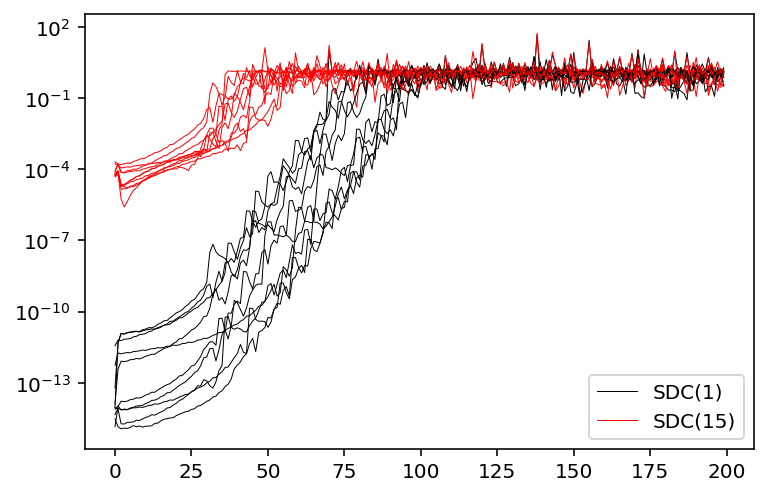

In [11]:
mean_error_per_interval = jnp.mean(jnp.sqrt(errors_unroll[:, :, :, 0] / errors_unroll[:, :, :, 1]), 2)
mean_error_per_interval_low = jnp.mean(jnp.sqrt(errors_unroll_low[:, :, :, 0] / errors_unroll_low[:, :, :, 1]), 2)

plt.yscale("log")
for i, (e1, e2) in enumerate(zip(mean_error_per_interval, mean_error_per_interval_low)):
    if i < mean_error_per_interval.shape[0] - 1:
        plt.plot(e1, color="black", linewidth=0.5)
        plt.plot(e2, color="red", linewidth=0.5)
    else:
        plt.plot(e1, color="black", linewidth=0.5, label="SDC(1)")
        plt.plot(e2, color="red", linewidth=0.5, label="SDC(15)")

plt.legend();